In [186]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping

import seaborn as sns
sns.set()

In [187]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [188]:
input_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_input.csv'
query_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_query.csv'
DATASET_SIZE = 1
LOOKBACK = 20

In [189]:
timeseries_df = pd.read_csv(input_dataset_path, sep='\t', index_col=0, header=None).astype(np.float32).sample(DATASET_SIZE)
TIME_SERIES_ID = timeseries_df.index.tolist()

In [190]:
def normalize(X, mu, sigma):
  return (X - mu)/sigma 

def reverse_normalize(X, mu, sigma):
  return X*sigma + mu 

def preprocess_timeseries(_timeseries, window=10, normalized=False, mu = None, sigma = None):
  if not normalized:
    if mu is None:
      mu = _timeseries.mean()
    if sigma is None:
      sigma = _timeseries.std()

    timeseries = normalize(_timeseries, mu, sigma)
  else:
    timeseries = _timeseries
  
  X = None
  for i in range(window, len(timeseries)):
    X_i = np.asarray(timeseries[i-window:i]).reshape((1, len(timeseries[i-window:i]), 1))
    X = np.concatenate((X, X_i)) if X is not None else X_i
    
  return X, mu, sigma

In [191]:
window_length = 10
X_all, mu, sigma = preprocess_timeseries(timeseries_df.to_numpy()[0], window_length)
print(X_all.shape)
X_train, X_test = train_test_split(X_all, test_size=0.33)

(720, 10, 1)


In [196]:
input_window = layers.Input(shape=(window_length,1))
x = layers.Conv1D(13, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = layers.MaxPooling1D(2, padding="same")(x) # 5 dims
x = layers.Conv1D(10, 8, activation="relu", padding="same")(x) # 10 dims
#x = BatchNormalization()(x)
x = layers.MaxPooling1D(2, padding="same")(x) # 5 dims
x = layers.Conv1D(3, 5, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = layers.MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = models.Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = layers.Conv1D(3, 5, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = layers.UpSampling1D(2)(x) # 6 dims
x = layers.Conv1D(10, 8, activation='relu', padding="same")(x) # 5 dims
x = layers.UpSampling1D(2)(x) # 6 dims
x = layers.Conv1D(13, 4, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = layers.UpSampling1D(2)(x) # 10 dims
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = models.Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


Model: "model_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 conv1d_317 (Conv1D)         (None, 10, 13)            52        
                                                                 
 max_pooling1d_129 (MaxPooli  (None, 5, 13)            0         
 ng1D)                                                           
                                                                 
 conv1d_318 (Conv1D)         (None, 5, 10)             1050      
                                                                 
 max_pooling1d_130 (MaxPooli  (None, 3, 10)            0         
 ng1D)                                                           
                                                                 
 conv1d_319 (Conv1D)         (None, 3, 3)              15

In [197]:
history = autoencoder.fit(X_train, X_train,
                epochs=25,
                batch_size=1024,
                shuffle=True,
                validation_data=(X_test, X_test))

decoded_stocks = autoencoder.predict(X_test)



Epoch 1/25
1/1 [==============================] - 2s 2s/step - loss: 0.6897 - val_loss: 0.6868
Epoch 2/25
1/1 [==============================] - 0s 80ms/step - loss: 0.6857 - val_loss: 0.6834
Epoch 3/25
1/1 [==============================] - 0s 72ms/step - loss: 0.6822 - val_loss: 0.6805
Epoch 4/25
1/1 [==============================] - 0s 78ms/step - loss: 0.6791 - val_loss: 0.6775
Epoch 5/25
1/1 [==============================] - 0s 73ms/step - loss: 0.6759 - val_loss: 0.6739
Epoch 6/25
1/1 [==============================] - 0s 88ms/step - loss: 0.6720 - val_loss: 0.6698
Epoch 7/25
1/1 [==============================] - 0s 71ms/step - loss: 0.6675 - val_loss: 0.6653
Epoch 8/25
1/1 [==============================] - 0s 72ms/step - loss: 0.6625 - val_loss: 0.6605
Epoch 9/25
1/1 [==============================] - 0s 65ms/step - loss: 0.6572 - val_loss: 0.6553
Epoch 10/25
1/1 [==============================] - 0s 71ms/step - loss: 0.6514 - val_loss: 0.6497
Epoch 11/25
1/1 [==============

In [198]:
def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 200))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)

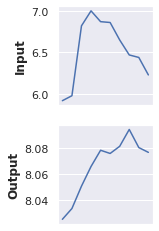

In [199]:
test_samples = 100
plot_examples(reverse_normalize(X_test, mu, sigma), reverse_normalize(autoencoder.predict(X_test), mu, sigma))